In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from darts import TimeSeries
from fredapi import Fred
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

## Download Data

In [54]:
# Initialize FRED API
fred = Fred(api_key='ada1a8ba0569ed784226f2c26db44ab1')

# Get the US GDP data from January 1993 to the current date
df = fred.get_series('GDP', observation_start='1975-01-01')

# Convert the data to a pandas DataFrame
df = df.to_frame(name='GDP')

# Reset the index to ensure the 'time' column is properly formatted
df = df.reset_index()

# Rename the columns to ensure proper alignment
df.columns = ['time', 'GDP']

# Convert the 'time' column to a datetime index
df['time'] = pd.to_datetime(df['time'])

# Set the 'time' column as the index
df.set_index('time', inplace=True)

# Create a TimeSeries object from the DataFrame
series = TimeSeries.from_dataframe(df, value_cols='GDP')

# Display the DataFrame to verify
print(df)

                  GDP
time                 
1975-01-01   1616.116
1975-04-01   1651.853
1975-07-01   1709.820
1975-10-01   1761.831
1976-01-01   1820.487
...               ...
2023-10-01  28296.967
2024-01-01  28624.069
2024-04-01  29016.714
2024-07-01  29374.914
2024-10-01  29700.580

[200 rows x 1 columns]


## Basic Theta Line Calculation

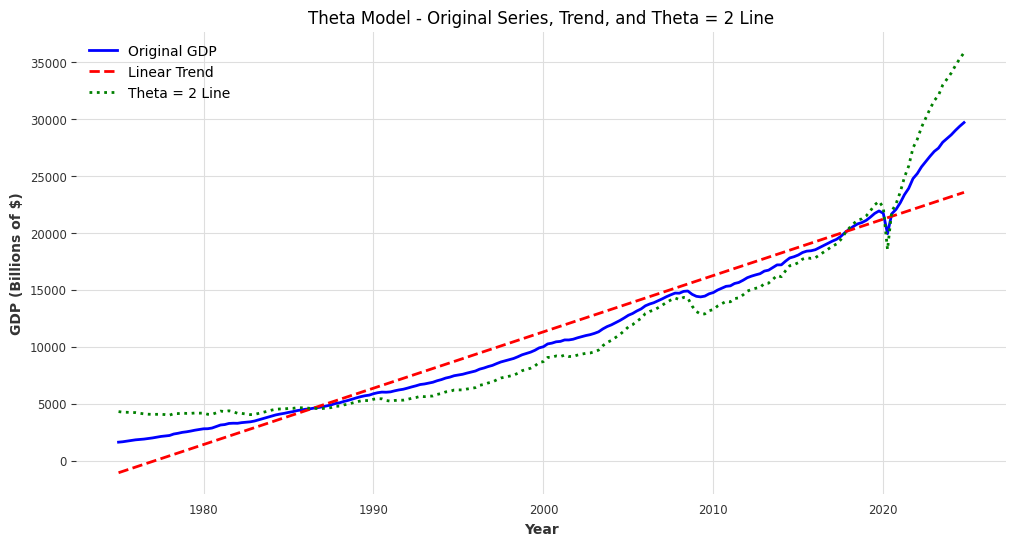

In [65]:
def compute_theta_lines(df, theta=2):
    """
    Compute the Theta lines for a given time series DataFrame.

    Parameters:
        df (pd.DataFrame): DataFrame with a datetime index and a single column of time series values.
        theta (float): Theta coefficient to adjust the series.

    Returns:
        pd.DataFrame: DataFrame with original series, trend component, and theta-transformed series.
    """
    df = df.copy()
    df = df.sort_index()
    
    # Convert time index to numerical values for regression
    time_numeric = np.arange(len(df)).reshape(-1, 1)
    
    # Fit a linear trend using least squares regression
    model = LinearRegression()
    model.fit(time_numeric, df['GDP'].values)
    
    # Estimate the local linear trend
    trend_component = model.predict(time_numeric)
    
    # Compute the Theta line
    df[f'Theta_{theta}'] = theta * df['GDP'] + (1 - theta) * trend_component
    df['Trend'] = trend_component
    
    return df

# Define the plotting function
def plot_theta_lines(df):
    """
    Plot the original time series, estimated trend, and Theta = 2 line.
    
    Parameters:
        df (pd.DataFrame): DataFrame with 'GDP', 'Trend', and 'Theta_2' columns.
    """
    plt.figure(figsize=(12, 6))

    # Plot Original GDP Series
    plt.plot(df.index, df['GDP'], label='Original GDP', color='blue', linewidth=2)

    # Plot Linear Trend
    plt.plot(df.index, df['Trend'], label='Linear Trend', linestyle='dashed', color='red', linewidth=2)

    # Plot Theta = 2 Line
    plt.plot(df.index, df['Theta_2'], label='Theta = 2 Line', linestyle='dotted', color='green', linewidth=2)

    # Labels and Legend
    plt.xlabel('Year')
    plt.ylabel('GDP (Billions of $)')
    plt.title('Theta Model - Original Series, Trend, and Theta = 2 Line')
    plt.legend()
    plt.grid(True)
    
    plt.show()

# Compute the Theta lines with theta = 2
df_theta = compute_theta_lines(df, theta=2)

# Plot the results
plot_theta_lines(df_theta)

## Combine into fitted line using weights. Also, add seasonality

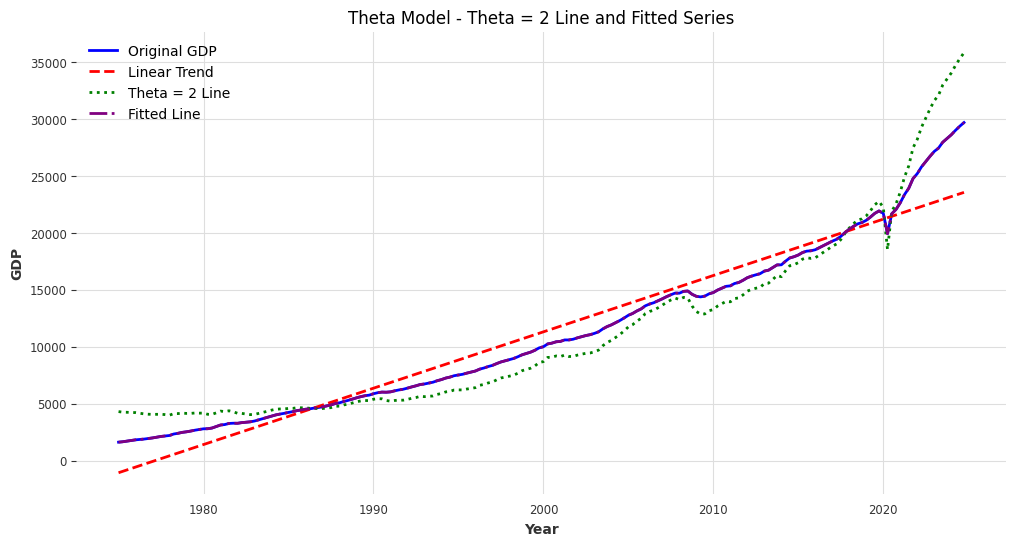

In [21]:
def compute_theta_line(df, target_var, theta, fit_method="additive", weight=0.5, period=None, seasonal_model="additive"):
    """
    Compute the linear trend, seasonal component (if applicable), Theta-transformed time series, and fitted series.

    Parameters:
        df (pd.DataFrame): DataFrame containing the time series.
        target_var (str): The name of the column representing the time series variable.
        theta (float): Theta coefficient for transformation.
        fit_method (str): 'additive' (default) or 'multiplicative' to combine Theta and Trend lines.
        weight (float): Weight factor for combining Theta and Trend lines (default = 0.5).
        period (int, optional): The period for seasonal decomposition.
        seasonal_model (str): 'additive' (default) or 'multiplicative' seasonal decomposition.

    Returns:
        pd.DataFrame: DataFrame with the original column, 'Trend', 'Theta_X', 'Seasonal', and 'Fitted' series.
    """
    df = df.copy()  # Prevent modifying the original DataFrame
    df = df.sort_index()  # Ensure chronological order

    # Convert time index to numerical values for regression
    time_numeric = np.arange(len(df)).reshape(-1, 1)

    # Fit a linear trend using least squares regression
    model = LinearRegression()
    model.fit(time_numeric, df[target_var].values)

    # Compute the linear trend (L_t)
    df['Trend'] = model.predict(time_numeric)

    # Extract seasonal component if period is provided
    if period:
        decomposition = seasonal_decompose(df[target_var], period=period, model=seasonal_model, extrapolate_trend=True)
        df['Seasonal'] = decomposition.seasonal
    else:
        df['Seasonal'] = 0  # No seasonal component

    # Compute the Theta-transformed series
    df[f'Theta_{theta}'] = theta * df[target_var] + (1 - theta) * df['Trend']

    # Compute the fitted series using the selected method:
    if fit_method == "additive":
        df['Fitted'] = weight * df[f'Theta_{theta}'] + (1 - weight) * df['Trend'] + df['Seasonal']
    elif fit_method == "multiplicative":
        df['Fitted'] = (df[f'Theta_{theta}'] ** weight) * (df['Trend'] ** (1 - weight)) + df['Seasonal']
    else:
        raise ValueError("fit_method must be 'additive' or 'multiplicative'.")

    return df

def plot_theta_line(df, target_var, theta):
    """
    Plot the original time series, estimated trend, Theta-transformed series, and fitted series.

    Parameters:
        df (pd.DataFrame): DataFrame containing the time series.
        target_var (str): The name of the column representing the time series variable.
        theta (float): The theta coefficient for transformation.
    """
    plt.figure(figsize=(12, 6))

    # Plot Original Series
    plt.plot(df.index, df[target_var], label=f'Original {target_var}', color='blue', linewidth=2)

    # Plot Linear Trend
    plt.plot(df.index, df['Trend'], label='Linear Trend', linestyle='dashed', color='red', linewidth=2)

    # Plot Theta Line
    plt.plot(df.index, df[f'Theta_{theta}'], label=f'Theta = {theta} Line', linestyle='dotted', color='green', linewidth=2)

    # Plot Fitted Line
    plt.plot(df.index, df['Fitted'], label='Fitted Line', linestyle='dashdot', color='purple', linewidth=2)

    # Labels and Legend
    plt.xlabel('Year')
    plt.ylabel(target_var)
    plt.title(f'Theta Model - Theta = {theta} Line and Fitted Series')
    plt.legend()
    plt.grid(True)
    
    plt.show()

# Example Usage
theta_value = 2  # Define the desired theta value
target_variable = 'GDP'  # Define the target variable in your dataset
fit_method = 'additive'  # Choose 'additive' or 'multiplicative'
weight_factor = 0.5  # Weight factor for combining the two lines
## seasonal_model = "additive"  # Choose 'additive' or 'multiplicative' for seasonal decomposition
## period = 4  # Define the period for seasonal decomposition

df_theta = compute_theta_line(df, target_variable, theta_value, fit_method, weight_factor,)  # Compute trend, theta, and fitted line
plot_theta_line(df_theta, target_variable, theta_value)  # Plot the results

In [22]:
# Assuming df is your DataFrame
summary = df_theta.describe()

print(summary)

                GDP         Trend  Seasonal       Theta_2        Fitted
count    200.000000    200.000000     200.0    200.000000    200.000000
mean   11247.541095  11247.541095       0.0  11247.541095  11247.541095
std     7355.314044   7164.764635       0.0   7899.431748   7355.314044
min     1616.116000  -1069.392655       0.0   3989.453308   1616.116000
25%     4864.956250   5089.074220       0.0   4647.774268   4864.956250
50%     9951.174000  11247.541095       0.0   8654.806905   9951.174000
75%    16235.221500  17406.007970       0.0  15064.435030  16235.221500
max    29700.580000  23564.474845       0.0  35836.685155  29700.580000


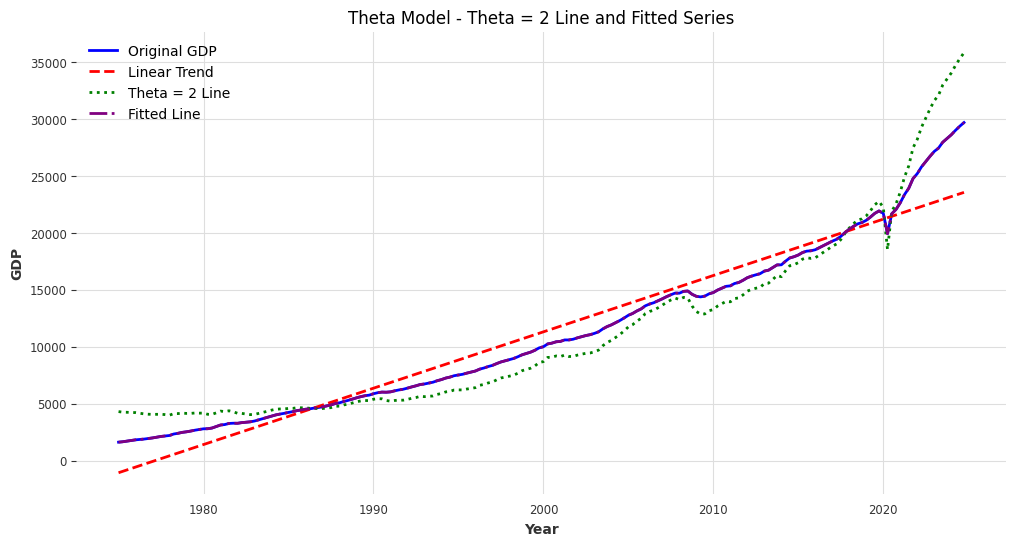

In [44]:
def compute_theta_line(df, target_var, theta, fit_method="additive", weight=0.5):
    """
    Compute the linear trend, Theta-transformed time series, and fitted series based on the chosen fit method.

    Parameters:
        df (pd.DataFrame): DataFrame containing the time series.
        target_var (str): The name of the column representing the time series variable.
        theta (float): Theta coefficient for transformation.
        fit_method (str): 'additive' (default) or 'multiplicative' to combine Theta and Trend lines.
        weight (float): Weight factor for combining Theta and Trend lines (default = 0.5).

    Returns:
        pd.DataFrame: DataFrame with the original column, 'Trend', 'Theta_X', and 'Fitted' series.
    """
    df = df.copy()  # Prevent modifying the original DataFrame
    df = df.sort_index()  # Ensure chronological order

    # Convert time index to numerical values for regression
    time_numeric = np.arange(len(df)).reshape(-1, 1)

    # Fit a linear trend using least squares regression
    model = LinearRegression()
    model.fit(time_numeric, df[target_var].values)

    # Compute the linear trend (L_t)
    df['Trend'] = model.predict(time_numeric)

    # Compute the Theta line:
    df[f'Theta_{theta}'] = theta * df[target_var] + (1 - theta) * df['Trend']

    # Compute the fitted series using the selected method:
    if fit_method == "additive":
        df['Fitted'] = weight * df[f'Theta_{theta}'] + (1 - weight) * df['Trend']
    elif fit_method == "multiplicative":
        df['Fitted'] = df[f'Theta_{theta}'] ** weight * df['Trend'] ** (1 - weight)
    else:
        raise ValueError("fit_method must be 'additive' or 'multiplicative'.")

    return df

def plot_theta_line(df, target_var, theta):
    """
    Plot the original time series, estimated trend, Theta-transformed series, and fitted series.

    Parameters:
        df (pd.DataFrame): DataFrame containing the time series.
        target_var (str): The name of the column representing the time series variable.
        theta (float): The theta coefficient for transformation.
    """
    plt.figure(figsize=(12, 6))

    # Plot Original Series
    plt.plot(df.index, df[target_var], label=f'Original {target_var}', color='blue', linewidth=2)

    # Plot Linear Trend
    plt.plot(df.index, df['Trend'], label='Linear Trend', linestyle='dashed', color='red', linewidth=2)

    # Plot Theta Line
    plt.plot(df.index, df[f'Theta_{theta}'], label=f'Theta = {theta} Line', linestyle='dotted', color='green', linewidth=2)

    # Plot Fitted Line
    plt.plot(df.index, df['Fitted'], label='Fitted Line', linestyle='dashdot', color='purple', linewidth=2)

    # Labels and Legend
    plt.xlabel('Year')
    plt.ylabel(target_var)
    plt.title(f'Theta Model - Theta = {theta} Line and Fitted Series')
    plt.legend()
    plt.grid(True)
    
    plt.show()

# Example Usage
theta_value = 2  # Define the desired theta value
target_variable = 'GDP'  # Define the target variable in your dataset
fit_method = 'additive'  # Choose 'additive' or 'multiplicative'
weight_factor = 0.5  # Weight factor for combining the two lines

df_theta = compute_theta_line(df, target_variable, theta_value, fit_method, weight_factor)  # Compute trend, theta, and fitted line
plot_theta_line(df_theta, target_variable, theta_value)  # Plot the results

In [32]:
df_theta

,GDP,Trend,Theta_2,Fitted
time,,,,
1975-01-01,1616.116,-1069.392655,4301.624655,1616.116
1975-04-01,1651.853,-945.604376,4249.310376,1651.853
1975-07-01,1709.820,-821.816097,4241.456097,1709.820
1975-10-01,1761.831,-698.027818,4221.689818,1761.831
1976-01-01,1820.487,-574.239539,4215.213539,1820.487
...,...,...,...,...
2023-10-01,28296.967,23069.321729,33524.612271,28296.967
2024-01-01,28624.069,23193.110008,34055.027992,28624.069
2024-04-01,29016.714,23316.898287,34716.529713,29016.714


## Optimized Theta Hyperparameter Selection Formula

In [40]:
def compute_theta_line(df, target_var, theta, fit_method="additive", weight=0.5):
    """
    Compute the linear trend, Theta-transformed time series, and fitted series based on the chosen fit method.

    Parameters:
        df (pd.DataFrame): DataFrame containing the time series.
        target_var (str): The name of the column representing the time series variable.
        theta (float): Theta coefficient for transformation.
        fit_method (str): 'additive' (default) or 'multiplicative' to combine Theta and Trend lines.
        weight (float): Weight factor for combining Theta and Trend lines (default = 0.5).

    Returns:
        pd.DataFrame: DataFrame with the original column, 'Trend', 'Theta_X', and 'Fitted' series.
    """
    df = df.copy()
    df = df.sort_index()

    # Convert time index to numerical values for regression
    time_numeric = np.arange(len(df)).reshape(-1, 1)

    # Fit a linear trend using least squares regression
    model = LinearRegression()
    model.fit(time_numeric, df[target_var].values)

    # Compute the linear trend (L_t)
    df['Trend'] = model.predict(time_numeric)

    # Compute the Theta line:
    df[f'Theta_{theta}'] = theta * df[target_var] + (1 - theta) * df['Trend']

    # Compute the fitted series using the selected method:
    if fit_method == "additive":
        df['Fitted'] = weight * df[f'Theta_{theta}'] + (1 - weight) * df['Trend']
    elif fit_method == "multiplicative":
        df['Fitted'] = df[f'Theta_{theta}'] ** weight * df['Trend'] ** (1 - weight)
    else:
        raise ValueError("fit_method must be 'additive' or 'multiplicative'.")

    return df

def compute_AIC(y_true, y_pred, k=2):
    """
    Compute Akaike Information Criterion (AIC) to evaluate model fit.

    Parameters:
        y_true (np.array): Original time series values.
        y_pred (np.array): Fitted values from the model.
        k (int): Number of estimated parameters (default=2).

    Returns:
        float: AIC score (lower is better).
    """
    n = len(y_true)
    residuals = y_true - y_pred
    rss = np.sum(residuals ** 2)
    aic = n * np.log(rss / n) + k * 2
    return aic

def optimize_theta(df, target_var, fit_method="additive"):
    """
    Optimize Theta and Weight values to minimize AIC.

    Parameters:
        df (pd.DataFrame): DataFrame containing the time series.
        target_var (str): The name of the column representing the time series variable.
        fit_method (str): 'additive' (default) or 'multiplicative'.

    Returns:
        dict: Optimized values for theta and weight.
    """
    def objective(params):
        theta, weight = params
        if not (0.1 <= theta <= 10 and 0.01 <= weight <= 0.99):
            return np.inf  # Penalize invalid values
        
        df_temp = compute_theta_line(df, target_var, theta, fit_method, weight)
        return compute_AIC(df[target_var].values, df_temp['Fitted'].values)

    # Initial guesses: theta=2, weight=0.5
    initial_guess = [2, 0.5]
    bounds = [(0.1, 10), (0.01, 0.99)]  # Theta range (0.1 to 10), weight range (0.01 to 0.99)

    # Optimize
    result = minimize(objective, initial_guess, bounds=bounds, method='L-BFGS-B')

    return {"theta": result.x[0], "weight": result.x[1], "AIC": result.fun}

# Example Usage
target_variable = 'GDP'  # Define the target variable in your dataset
fit_method = 'additive'  # Choose 'additive' or 'multiplicative'

optimized_params = optimize_theta(df, target_variable, fit_method)
optimal_theta = optimized_params["theta"]
optimal_weight = optimized_params["weight"]

# Compute the best-fitting Theta model
df_optimized = compute_theta_line(df, target_variable, optimal_theta, fit_method, optimal_weight)

print(f"Optimized Theta: {optimal_theta:.4f}, Optimized Weight: {optimal_weight:.4f}, AIC: {optimized_params['AIC']:.2f}")

Optimized Theta: 2.0000, Optimized Weight: 0.5000, AIC: -6921.60


## Embed the compute_theta_line formula into the Optimized_Theta formula

In [7]:
def compute_AIC(y_true, y_pred, k=2):
    """
    Compute Akaike Information Criterion (AIC) to evaluate model fit.
    """
    n = len(y_true)
    residuals = y_true - y_pred
    rss = np.sum(residuals ** 2)
    aic = n * np.log(rss / n) + k * 2
    return aic

def compute_theta_line(df, target_var, theta, fit_method="additive", weight=0.5):
    """
    Compute the linear trend, Theta-transformed time series, and fitted series.
    """
    df = df.copy()
    df = df.sort_index()
    
    time_numeric = np.arange(len(df)).reshape(-1, 1)
    model = LinearRegression()
    model.fit(time_numeric, df[target_var].values)
    
    df['Trend'] = model.predict(time_numeric)
    df[f'Theta_{theta}'] = theta * df[target_var] + (1 - theta) * df['Trend']
    
    if fit_method == "additive":
        df['Fitted'] = weight * df[f'Theta_{theta}'] + (1 - weight) * df['Trend']
    elif fit_method == "multiplicative":
        df['Fitted'] = df[f'Theta_{theta}'] ** weight * df['Trend'] ** (1 - weight)
    else:
        raise ValueError("fit_method must be 'additive' or 'multiplicative'.")
    
    return df

def optimize_theta(df, target_var, fit_method="additive"):
    """
    Optimize Theta and Weight values to minimize AIC.
    """
    def objective(params):
        theta, weight = params
        if not (0.1 <= theta <= 10 and 0.01 <= weight <= 0.99):
            return np.inf  # Penalize invalid values
        
        df_temp = compute_theta_line(df, target_var, theta, fit_method, weight)
        return compute_AIC(df[target_var].values, df_temp['Fitted'].values)
    
    initial_guess = [2, 0.5]
    bounds = [(0.1, 10), (0.01, 0.99)]
    result = minimize(objective, initial_guess, bounds=bounds, method='L-BFGS-B')
    
    return result.x[0], result.x[1], result.fun

def OptimizedTheta(df, target_var, fit_method="additive", theta=None, weight=None):
    """
    Compute the optimized Theta model, optimizing hyperparameters if not provided.
    """
    if theta is None or weight is None:
        theta, weight, aic = optimize_theta(df, target_var, fit_method)
    else:
        df_temp = compute_theta_line(df, target_var, theta, fit_method, weight)
        aic = compute_AIC(df[target_var].values, df_temp['Fitted'].values)
    
    df_optimized = compute_theta_line(df, target_var, theta, fit_method, weight)
    
    return df_optimized, {"theta": theta, "weight": weight, "AIC": aic}
# Example Usage
target_variable = 'GDP'  # Define the target variable in your dataset
fit_method = 'additive'  # Choose 'additive' or 'multiplicative'

df_optimized, optimized_params = OptimizedTheta(df, target_variable, fit_method)

print(f"Optimized Theta: {optimized_params['theta']:.4f}, Optimized Weight: {optimized_params['weight']:.4f}, AIC: {optimized_params['AIC']:.2f}")

Optimized Theta: 2.0000, Optimized Weight: 0.5000, AIC: -6921.60


In [8]:
# Display the contents of df_optimized
print(df_optimized)

                  GDP         Trend     Theta_2.0     Fitted
time                                                        
1975-01-01   1616.116  -1069.392655   4301.624655   1616.116
1975-04-01   1651.853   -945.604376   4249.310376   1651.853
1975-07-01   1709.820   -821.816097   4241.456097   1709.820
1975-10-01   1761.831   -698.027818   4221.689818   1761.831
1976-01-01   1820.487   -574.239539   4215.213539   1820.487
...               ...           ...           ...        ...
2023-10-01  28296.967  23069.321729  33524.612271  28296.967
2024-01-01  28624.069  23193.110008  34055.027992  28624.069
2024-04-01  29016.714  23316.898287  34716.529713  29016.714
2024-07-01  29374.914  23440.686566  35309.141434  29374.914
2024-10-01  29700.580  23564.474845  35836.685155  29700.580

[200 rows x 4 columns]


## Add seasonality option to Optimized Theta Hyperparameter Selection

In [34]:
def compute_AIC(y_true, y_pred, k=2):
    """
    Compute Akaike Information Criterion (AIC) to evaluate model fit.
    """
    n = len(y_true)
    residuals = y_true - y_pred
    rss = np.sum(residuals ** 2)
    aic = n * np.log(rss / n) + k * 2
    return aic

def compute_theta_line(df, target_var, theta, fit_method="additive", weight=0.5, period=None):
    """
    Compute the linear trend, seasonal component (if applicable), Theta-transformed time series, and fitted series.
    """
    df = df.copy()
    df = df.sort_index()
    
    time_numeric = np.arange(len(df)).reshape(-1, 1)
    model = LinearRegression()
    model.fit(time_numeric, df[target_var].values)
    
    df['Trend'] = model.predict(time_numeric)
    
    # Extract seasonal component if period is provided
    if period:
        decomposition = seasonal_decompose(df[target_var], period=period, model='additive', extrapolate_trend=True)
        df['Seasonal'] = decomposition.seasonal
    else:
        df['Seasonal'] = 0  # No seasonal component

    # Compute Theta-transformed series
    df[f'Theta_{theta}'] = theta * df[target_var] + (1 - theta) * df['Trend']

    # Compute fitted series
    if fit_method == "additive":
        df['Fitted'] = weight * df[f'Theta_{theta}'] + (1 - weight) * df['Trend'] + df['Seasonal']
    elif fit_method == "multiplicative":
        df['Fitted'] = (df[f'Theta_{theta}'] ** weight) * (df['Trend'] ** (1 - weight)) + df['Seasonal']
    else:
        raise ValueError("fit_method must be 'additive' or 'multiplicative'.")
    
    return df

def optimize_theta(df, target_var, fit_method="additive", period=None):
    """
    Optimize Theta and Weight values to minimize AIC.
    """
    def objective(params):
        theta, weight = params
        if not (0.1 <= theta <= 10 and 0.01 <= weight <= 0.99):
            return np.inf  # Penalize invalid values
        
        df_temp = compute_theta_line(df, target_var, theta, fit_method, weight, period)
        return compute_AIC(df[target_var].values, df_temp['Fitted'].values)
    
    initial_guess = [2, 0.5]
    bounds = [(0.1, 10), (0.01, 0.99)]
    result = minimize(objective, initial_guess, bounds=bounds, method='L-BFGS-B')
    
    return result.x[0], result.x[1], result.fun

def OptimizedTheta(df, target_var, fit_method="additive", theta=None, weight=None, period=None):
    """
    Compute the optimized Theta model, optimizing hyperparameters if not provided.
    """
    if theta is None or weight is None:
        theta, weight, aic = optimize_theta(df, target_var, fit_method, period)
    else:
        df_temp = compute_theta_line(df, target_var, theta, fit_method, weight, period)
        aic = compute_AIC(df[target_var].values, df_temp['Fitted'].values)
    
    df_optimized = compute_theta_line(df, target_var, theta, fit_method, weight, period)
    
    return df_optimized, {"theta": theta, "weight": weight, "AIC": aic}
    
# Example Usage
target_variable = 'GDP'  # Define the target variable in your dataset
fit_method = 'additive'  # Choose 'additive' or 'multiplicative'
period = 4  # Quarterly data

df_optimized, optimized_params = OptimizedTheta(df, target_variable, fit_method, period=period)

print(f"Optimized Theta: {optimized_params['theta']:.4f}, Optimized Weight: {optimized_params['weight']:.4f}, AIC: {optimized_params['AIC']:.2f}")

Optimized Theta: 1.9998, Optimized Weight: 0.5000, AIC: 1106.49


In [35]:
df_optimized

,GDP,Trend,Seasonal,Theta_1.9998400751943144,Fitted
time,,,,,
1975-01-01,1616.116,-1069.392655,-1.217692,4301.195176,1614.462045
1975-04-01,1651.853,-945.604376,-25.200684,4248.894978,1626.230357
1975-07-01,1709.820,-821.816097,11.507651,4241.051226,1720.916384
1975-10-01,1761.831,-698.027818,14.910726,4221.296426,1776.342120
1976-01-01,1820.487,-574.239539,-1.217692,4214.830563,1818.880283
...,...,...,...,...,...
2023-10-01,28296.967,23069.321729,14.910726,33523.776240,28311.028491
2024-01-01,28624.069,23193.110008,-1.217692,34054.159447,28621.969045
2024-04-01,29016.714,23316.898287,-25.200684,34715.618171,28990.587376


## Add seasonal component hyperparameter selection as well

In [33]:
def compute_AIC(y_true, y_pred, k=2):
    """
    Compute Akaike Information Criterion (AIC) to evaluate model fit.
    """
    n = len(y_true)
    residuals = y_true - y_pred
    rss = np.sum(residuals ** 2)
    aic = n * np.log(rss / n) + k * 2
    return aic

def compute_theta_line(df, target_var, theta, fit_method="additive", weight=0.5, period=None, seasonal_model="additive"):
    """
    Compute the linear trend, seasonal component (if applicable), Theta-transformed time series, and fitted series.
    """
    df = df.copy()
    df = df.sort_index()
    
    time_numeric = np.arange(len(df)).reshape(-1, 1)
    model = LinearRegression()
    model.fit(time_numeric, df[target_var].values)
    
    df['Trend'] = model.predict(time_numeric)
    
    # Extract seasonal component if period is provided
    if period:
        decomposition = seasonal_decompose(df[target_var], period=period, model=seasonal_model, extrapolate_trend=True)
        df['Seasonal'] = decomposition.seasonal
    else:
        df['Seasonal'] = 0  # No seasonal component

    # Compute Theta-transformed series
    df[f'Theta_{theta}'] = theta * df[target_var] + (1 - theta) * df['Trend']

    # Compute fitted series
    if fit_method == "additive":
        df['Fitted'] = weight * df[f'Theta_{theta}'] + (1 - weight) * df['Trend'] + df['Seasonal']
    elif fit_method == "multiplicative":
        df['Fitted'] = (df[f'Theta_{theta}'] ** weight) * (df['Trend'] ** (1 - weight)) + df['Seasonal']
    else:
        raise ValueError("fit_method must be 'additive' or 'multiplicative'.")
    
    return df

def optimize_theta(df, target_var, fit_method="additive", period=None, seasonal_model="additive"):
    """
    Optimize Theta and Weight values to minimize AIC.
    """
    def objective(params):
        theta, weight = params
        if not (0.1 <= theta <= 10 and 0.01 <= weight <= 0.99):
            return np.inf  # Penalize invalid values
        
        df_temp = compute_theta_line(df, target_var, theta, fit_method, weight, period, seasonal_model)
        return compute_AIC(df[target_var].values, df_temp['Fitted'].values)
    
    initial_guess = [2, 0.5]
    bounds = [(0.1, 10), (0.01, 0.99)]
    result = minimize(objective, initial_guess, bounds=bounds, method='L-BFGS-B')
    
    return result.x[0], result.x[1], result.fun

def OptimizedTheta(df, target_var, fit_method="additive", theta=None, weight=None, period=None, seasonal_model="additive"):
    """
    Compute the optimized Theta model, optimizing hyperparameters if not provided.
    """
    if theta is None or weight is None:
        theta, weight, aic = optimize_theta(df, target_var, fit_method, period, seasonal_model)
    else:
        df_temp = compute_theta_line(df, target_var, theta, fit_method, weight, period, seasonal_model)
        aic = compute_AIC(df[target_var].values, df_temp['Fitted'].values)
    
    df_optimized = compute_theta_line(df, target_var, theta, fit_method, weight, period, seasonal_model)
    
    return df_optimized, {"theta": theta, "weight": weight, "AIC": aic}
    
# Example Usage
target_variable = 'GDP'  # Define the target variable in your dataset
fit_method = 'additive'  # Choose 'additive' or 'multiplicative'
## seasonal_model = 'additive'  # Choose 'additive' or 'multiplicative'
## period = 4  # Quarterly data

df_optimized, optimized_params = OptimizedTheta(df, target_variable, fit_method)

print(f"Optimized Theta: {optimized_params['theta']:.4f}, Optimized Weight: {optimized_params['weight']:.4f}, AIC: {optimized_params['AIC']:.2f}")

Optimized Theta: 2.0000, Optimized Weight: 0.5000, AIC: -6921.60


## Standard Theta Model Forecast Formula

In [43]:
def compute_AIC(y_true, y_pred, k=2):
    """
    Compute Akaike Information Criterion (AIC) to evaluate model fit.
    """
    n = len(y_true)
    residuals = y_true - y_pred
    rss = np.sum(residuals ** 2)
    aic = n * np.log(rss / n) + k * 2
    return aic

def compute_theta_line(df, target_var, theta, fit_method="additive", weight=0.5, period=None, seasonal_model="additive"):
    """
    Compute the linear trend, seasonal component (if applicable), Theta-transformed time series, and fitted series.
    """
    df = df.copy().sort_index()
    
    # Fit Linear Trend
    time_numeric = np.arange(len(df)).reshape(-1, 1)
    model = LinearRegression()
    model.fit(time_numeric, df[target_var].values)
    df['Trend'] = model.predict(time_numeric)
    
    # Extract seasonal component if period is provided
    if period:
        decomposition = seasonal_decompose(df[target_var], period=period, model=seasonal_model, extrapolate_trend=True)
        df['Seasonal'] = decomposition.seasonal
    else:
        df['Seasonal'] = 0  # No seasonal component

    # Compute Theta-transformed series
    df[f'Theta_{theta}'] = theta * df[target_var] + (1 - theta) * df['Trend']

    # Compute fitted series
    if fit_method == "additive":
        df['Fitted'] = weight * df[f'Theta_{theta}'] + (1 - weight) * df['Trend'] + df['Seasonal']
    elif fit_method == "multiplicative":
        df['Fitted'] = (df[f'Theta_{theta}'] ** weight) * (df['Trend'] ** (1 - weight)) + df['Seasonal']
    else:
        raise ValueError("fit_method must be 'additive' or 'multiplicative'.")
    
    return df

def forecast_theta(df, target_var, theta, fit_method="additive", weight=0.5, period=None, seasonal_model="additive", horizon=10):
    """
    Forecast future values using:
    - Linear trend for trend component
    - SARIMA for seasonal component
    - Simple Exponential Smoothing for Theta component
    """
    df = compute_theta_line(df, target_var, theta, fit_method, weight, period, seasonal_model)
    
    # Generate future time index
    last_date = df.index[-1]
    freq = pd.infer_freq(df.index)
    future_dates = pd.date_range(start=last_date, periods=horizon + 1, freq=freq)[1:]

    # Forecast Trend Component
    future_index = np.arange(len(df), len(df) + horizon).reshape(-1, 1)
    trend_model = LinearRegression()
    trend_model.fit(np.arange(len(df)).reshape(-1, 1), df[target_var].values)
    trend_forecast = trend_model.predict(future_index)

    # Forecast Seasonal Component (SARIMA)
    if period:
        sarima_model = SARIMAX(df[target_var], order=(1, 1, 1), seasonal_order=(1, 1, 1, period))
        sarima_fit = sarima_model.fit(disp=False)
        seasonal_forecast = sarima_fit.forecast(steps=horizon)
    else:
        seasonal_forecast = np.zeros(horizon)

    # Forecast Theta Component (Simple Exponential Smoothing)
    ses_model = SimpleExpSmoothing(df[f'Theta_{theta}']).fit()
    theta_forecast = ses_model.forecast(horizon)

    # Compute Final Forecast
    if fit_method == "additive":
        fitted_forecast = weight * theta_forecast + (1 - weight) * trend_forecast + seasonal_forecast
    elif fit_method == "multiplicative":
        fitted_forecast = (theta_forecast ** weight) * (trend_forecast ** (1 - weight)) + seasonal_forecast
    else:
        raise ValueError("fit_method must be 'additive' or 'multiplicative'.")
    
    # Construct Forecast DataFrame with Correct Date Index
    forecast_df = pd.DataFrame({
        'Trend_Forecast': trend_forecast,
        'Seasonal_Forecast': seasonal_forecast,
        f'Theta_{theta}_Forecast': theta_forecast,
        'Fitted_Forecast': fitted_forecast
    }, index=future_dates)

    return forecast_df

target_variable = 'GDP'
fit_method = 'additive'
period = 4  # Quarterly data
horizon = 10
theta_value = 2
weight_value = 0.5

df_forecast = forecast_theta(df, target_variable, theta_value, fit_method, weight_value, period, "additive", horizon)
print(df_forecast)

/Users/alexbactat/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/alexbactat/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


            Trend_Forecast  Seasonal_Forecast  Theta_2_Forecast  \
2025-01-01    23688.263124       29927.038702      35834.032538   
2025-04-01    23812.051403       30134.920566      35834.032538   
2025-07-01    23935.839682       30559.829523      35834.032538   
2025-10-01    24059.627961       30924.238438      35834.032538   
2026-01-01    24183.416240       31151.818608      35834.032538   
2026-04-01    24307.204518       31364.887093      35834.032538   
2026-07-01    24430.992797       31787.271915      35834.032538   
2026-10-01    24554.781076       32151.824009      35834.032538   
2027-01-01    24678.569355       32378.409258      35834.032538   
2027-04-01    24802.357634       32592.298852      35834.032538   

            Fitted_Forecast  
2025-01-01     59688.186533  
2025-04-01     59957.962537  
2025-07-01     60444.765632  
2025-10-01     60871.068687  
2026-01-01     61160.542996  
2026-04-01     61435.505621  
2026-07-01     61919.784582  
2026-10-01     62346.2

/Users/alexbactat/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


## Optimized Theta Model Forecast Formula

In [ ]:
def compute_AIC(y_true, y_pred, k=2):
    n = len(y_true)
    residuals = y_true - y_pred
    rss = np.sum(residuals ** 2)
    aic = n * np.log(rss / n) + k * 2
    return aic

def compute_theta_line(df, target_var, theta, fit_method="additive", weight=0.5, period=None, seasonal_model="additive"):
    df = df.copy().sort_index()
    
    # Fit the linear trend
    time_numeric = np.arange(len(df)).reshape(-1, 1)
    model = LinearRegression()
    model.fit(time_numeric, df[target_var].values)
    df['Trend'] = model.predict(time_numeric)
    
    # Seasonal decomposition (if period is provided)
    if period:
        decomposition = seasonal_decompose(df[target_var], period=period, model=seasonal_model, extrapolate_trend=True)
        df['Seasonal'] = decomposition.seasonal
    else:
        df['Seasonal'] = 1 if seasonal_model == "multiplicative" else 0  # Neutral element for multiplication or addition

    # Compute Theta line
    df[f'Theta'] = theta * df[target_var] + (1 - theta) * df['Trend']

    # Combine components based on fit_method and seasonal_model
    if fit_method == "additive":
        if seasonal_model == "additive":
            df['Fitted'] = weight * df[f'Theta'] + (1 - weight) * df['Trend'] + df['Seasonal']
        else:  # Multiplicative seasonal model
            df['Fitted'] = weight * df[f'Theta'] + (1 - weight) * df['Trend'] * df['Seasonal']
    elif fit_method == "multiplicative":
        if seasonal_model == "additive":
            df['Fitted'] = (df[f'Theta'] ** weight) * (df['Trend'] ** (1 - weight)) + df['Seasonal']
        else:  # Multiplicative seasonal model
            df['Fitted'] = (df[f'Theta'] ** weight) * (df['Trend'] ** (1 - weight)) * df['Seasonal']
    else:
        raise ValueError("fit_method must be 'additive' or 'multiplicative'.")
    
    return df

def optimize_theta(df, target_var, fit_method="additive", period=None, seasonal_model="additive"):
    def objective(params):
        theta, weight = params
        if not (0.1 <= theta <= 10 and 0.01 <= weight <= 0.99):
            return np.inf  
        df_temp = compute_theta_line(df, target_var, theta, fit_method, weight, period, seasonal_model)
        return compute_AIC(df[target_var].values, df_temp['Fitted'].values)
    
    initial_guess = [2, 0.5]
    bounds = [(0.1, 10), (0.01, 0.99)]
    result = minimize(objective, initial_guess, bounds=bounds, method='L-BFGS-B')
    
    return result.x[0], result.x[1], result.fun

def forecast_theta(df, target_var, theta, fit_method="additive", weight=0.5, period=None, seasonal_model="additive", horizon=10):
    df = compute_theta_line(df, target_var, theta, fit_method, weight, period, seasonal_model)
    
    last_date = df.index[-1]
    freq = pd.infer_freq(df.index)
    future_dates = pd.date_range(start=last_date, periods=horizon + 1, freq=freq)[1:]

    # Forecast trend
    future_index = np.arange(len(df), len(df) + horizon).reshape(-1, 1)
    trend_model = LinearRegression()
    trend_model.fit(np.arange(len(df)).reshape(-1, 1), df[target_var].values)
    trend_forecast = trend_model.predict(future_index)
    
    # Forecast seasonal component (if period is provided)
    if period:
        sarima_model = SARIMAX(df[target_var], order=(1, 1, 1), seasonal_order=(1, 1, 1, period))
        sarima_fit = sarima_model.fit(disp=False)
        seasonal_forecast = sarima_fit.forecast(steps=horizon)
    else:
        seasonal_forecast = 1 if seasonal_model == "multiplicative" else 0  # Neutral element for multiplication or addition

    # Forecast Theta line
    ses_model = SimpleExpSmoothing(df[f'Theta']).fit()
    theta_forecast = ses_model.forecast(horizon)

    # Combine components based on fit_method and seasonal_model
    if fit_method == "additive":
        if seasonal_model == "additive":
            fitted_forecast = weight * theta_forecast + (1 - weight) * trend_forecast + seasonal_forecast
        else:  # Multiplicative seasonal model
            fitted_forecast = weight * theta_forecast + (1 - weight) * trend_forecast * seasonal_forecast
    elif fit_method == "multiplicative":
        if seasonal_model == "additive":
            fitted_forecast = (theta_forecast ** weight) * (trend_forecast ** (1 - weight)) + seasonal_forecast
        else:  # Multiplicative seasonal model
            fitted_forecast = (theta_forecast ** weight) * (trend_forecast ** (1 - weight)) * seasonal_forecast
    else:
        raise ValueError("fit_method must be 'additive' or 'multiplicative'.")
    
    # Create forecast DataFrame
    forecast_df = pd.DataFrame({
        'Trend_Forecast': trend_forecast,
        'Seasonal_Forecast': seasonal_forecast,
        f'Theta_Forecast': theta_forecast,
        'Fitted_Forecast': fitted_forecast
    }, index=future_dates)

    return forecast_df

def OptimizedTheta(df, target_var, fit_method="additive", theta=None, weight=None, period=None, seasonal_model="additive", horizon=10):
    if theta is None or weight is None:
        theta, weight, aic = optimize_theta(df, target_var, fit_method, period, seasonal_model)
    else:
        df_temp = compute_theta_line(df, target_var, theta, fit_method, weight, period, seasonal_model)
        aic = compute_AIC(df[target_var].values, df_temp['Fitted'].values)
    
    df_optimized = compute_theta_line(df, target_var, theta, fit_method, weight, period, seasonal_model)
    forecast_df = forecast_theta(df, target_var, theta, fit_method, weight, period, seasonal_model, horizon)
    
    return df_optimized, forecast_df, {"theta": theta, "weight": weight, "AIC": aic}

# Example Usage
target_variable = 'GDP'
fit_method = 'additive'
seasonal_model = 'multiplicative'  # Change to 'additive' if needed
period = 4  
horizon = 10

df_optimized, df_forecast, optimized_params = OptimizedTheta(
    df, target_variable, fit_method, period=period, seasonal_model=seasonal_model, horizon=horizon
)

print(f"Optimized Theta: {optimized_params['theta']:.4f}, Optimized Weight: {optimized_params['weight']:.4f}, AIC: {optimized_params['AIC']:.2f}")
print(df_forecast)

Optimized Theta: 2.0000, Optimized Weight: 0.5000, AIC: -6921.60
            Trend_Forecast  Seasonal_Forecast  Theta_Forecast  Fitted_Forecast
2025-01-01    23688.263124                  0    35834.032538     29761.147831
2025-04-01    23812.051403                  0    35834.032538     29823.041970
2025-07-01    23935.839682                  0    35834.032538     29884.936110
2025-10-01    24059.627961                  0    35834.032538     29946.830249
2026-01-01    24183.416240                  0    35834.032538     30008.724389
2026-04-01    24307.204518                  0    35834.032538     30070.618528
2026-07-01    24430.992797                  0    35834.032538     30132.512668
2026-10-01    24554.781076                  0    35834.032538     30194.406807
2027-01-01    24678.569355                  0    35834.032538     30256.300947
2027-04-01    24802.357634                  0    35834.032538     30318.195086


/Users/alexbactat/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


In [101]:
print(df_forecast)

            Trend_Forecast  Seasonal_Forecast  Theta_Forecast  Fitted_Forecast
2025-01-01    23688.263124                  0    35834.032538     29761.147831
2025-04-01    23812.051403                  0    35834.032538     29823.041970
2025-07-01    23935.839682                  0    35834.032538     29884.936110
2025-10-01    24059.627961                  0    35834.032538     29946.830249
2026-01-01    24183.416240                  0    35834.032538     30008.724389
2026-04-01    24307.204518                  0    35834.032538     30070.618528
2026-07-01    24430.992797                  0    35834.032538     30132.512668
2026-10-01    24554.781076                  0    35834.032538     30194.406807
2027-01-01    24678.569355                  0    35834.032538     30256.300947
2027-04-01    24802.357634                  0    35834.032538     30318.195086


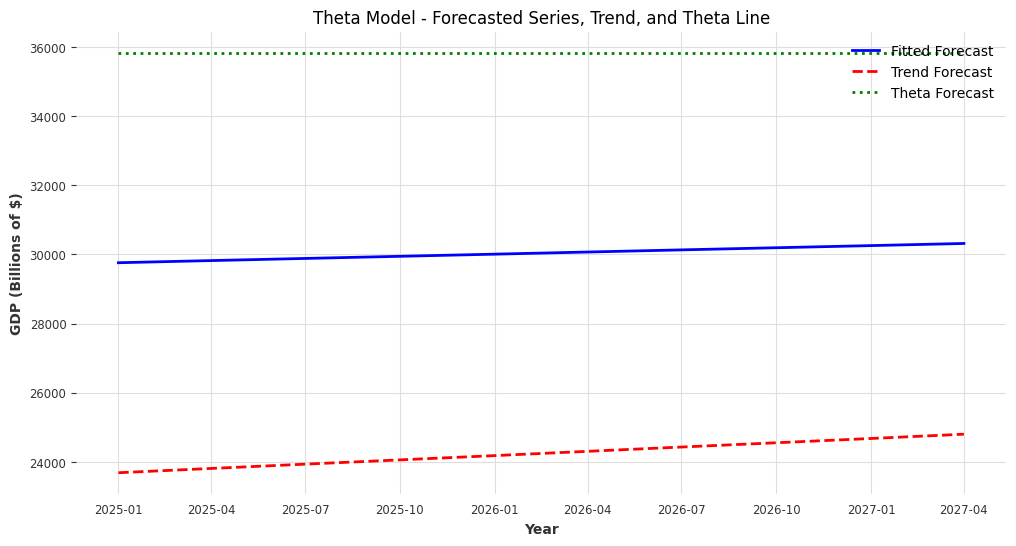

Optimized Theta: 2.0000, Optimized Weight: 0.5000, AIC: -6921.60
            Trend_Forecast  Seasonal_Forecast  Theta_Forecast  Fitted_Forecast
2025-01-01    23688.263124                  0    35834.032538     29761.147831
2025-04-01    23812.051403                  0    35834.032538     29823.041970
2025-07-01    23935.839682                  0    35834.032538     29884.936110
2025-10-01    24059.627961                  0    35834.032538     29946.830249
2026-01-01    24183.416240                  0    35834.032538     30008.724389
2026-04-01    24307.204518                  0    35834.032538     30070.618528
2026-07-01    24430.992797                  0    35834.032538     30132.512668
2026-10-01    24554.781076                  0    35834.032538     30194.406807
2027-01-01    24678.569355                  0    35834.032538     30256.300947
2027-04-01    24802.357634                  0    35834.032538     30318.195086


In [102]:
# Define the plotting function
def plot_theta_forecast(df_forecast):
    """
    Plot the forecasted time series, trend, and Theta line.
    
    Parameters:
        df_forecast (pd.DataFrame): DataFrame with 'Trend_Forecast', 'Theta_Forecast', and 'Fitted_Forecast' columns.
    """
    plt.figure(figsize=(12, 6))

    # Plot Fitted Forecast
    plt.plot(df_forecast.index, df_forecast['Fitted_Forecast'], label='Fitted Forecast', color='blue', linewidth=2)

    # Plot Trend Forecast
    plt.plot(df_forecast.index, df_forecast['Trend_Forecast'], label='Trend Forecast', linestyle='dashed', color='red', linewidth=2)

    # Plot Theta Forecast
    plt.plot(df_forecast.index, df_forecast['Theta_Forecast'], label='Theta Forecast', linestyle='dotted', color='green', linewidth=2)

    # Labels and Legend
    plt.xlabel('Year')
    plt.ylabel('GDP (Billions of $)')
    plt.title('Theta Model - Forecasted Series, Trend, and Theta Line')
    plt.legend()
    plt.grid(True)
    
    plt.show()

# Plot the forecasted data
plot_theta_forecast(df_forecast)

print(f"Optimized Theta: {optimized_params['theta']:.4f}, Optimized Weight: {optimized_params['weight']:.4f}, AIC: {optimized_params['AIC']:.2f}")
print(df_forecast)